In [113]:
!pip install pyLDAvis
!pip install bs4
!pip install googletrans
!pip install wordcloud
!pip install svgling

     |████████████████████████████████| 66 kB 3.6 MB/s eta 0:00:011


In [114]:
import requests
import re
import pandas as pd
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis
import svgling

from bs4 import BeautifulSoup
from time import time, sleep
from random import randint
from tqdm import tqdm
from googletrans import Translator
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords, treebank
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from pyLDAvis import sklearn as sklearn_lda
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from wordcloud import WordCloud

nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('treebank')
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('stopwords')
sns.set_style('whitegrid')
%matplotlib inline

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/jupyter/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package treebank to /home/jupyter/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already 

# Web scraping process

In [3]:
def honestdoc_comment(url):
    """
    This function is to scrap data from a webboard (https://www.honestdocs.com).

    INPUT
    url : String
      URL of the target website
    
    OUTPUT
    comment : List
      List of comments
    score : List
      List of rating score
    """
    #create connection
    data = requests.get(url)
    print("requests code : {}".format(data.status_code)) 
    print("note\n2xx: success\n4xx, 5xx: error")
    
    #scrape comment and score
    start_time = time() #start scraping data from page1
    r = requests.get(url, params=dict(query="web scraping",page=1)) 
    soup = BeautifulSoup(r.text,"html.parser")
    n = len(soup.find_all("div",{"class":"comments__content"})) #find n of items in the page
    
    #extract each item
    comment = [soup.find_all("div",
                             {"class":"comments__content"})[i].get_text().strip() for i in range(0,n)]
    score = [soup.find_all("span",
                           {"class":"stars star-rating"})[i].attrs["data-score"] for i in range(0,n)]
    elapsed_time = time() - start_time #finish scraping data from page1
    print("Time used for scraping data from page - 1 : {} s".format(elapsed_time))
    sleep(randint(1,3)) #mimic human behavior
           
    p = 2 #start scraping data from page2
    while n > 0: #until the number of items in a page = 0
        start_time = time() 
        r = requests.get(url, params=dict(query="web scraping",page=p))
        soup = BeautifulSoup(r.text,"html.parser")
        n = len(soup.find_all("div",{"class":"comments__content"}))
        [comment.append(soup.find_all("div",
                                      {"class":"comments__content"})[i].get_text().strip()) for i in range(0,n)]
        [score.append(soup.find_all("span",
                                    {"class":"stars star-rating"})[i].attrs["data-score"]) for i in range(0,n)]
        elapsed_time = time() - start_time
        print("Time used for scraping data from page - {} : {} s".format(p, elapsed_time))
        p +=1
        sleep(randint(1,3))
    
    #backup data 
    pd.DataFrame({"comment": comment, 
                  "score": score}).to_csv("comment_"+str(url[url.rfind("/")+1:]) + ".csv", index=False)
    
    return comment, score

In [4]:
def sent_level_polarity(df, target):
  sentences = []
  scores = []
  for i in df.index:
    en = df.loc[i, target]
    score = df.loc[i, "score"]
    s = sent_tokenize(en)
    sentences = sentences + s
    scores = scores + [score]*len(s)
  return pd.DataFrame({"sentences": sentences, "scores": scores})

In [5]:
def predict_sentiment(sentence):
  sa = SentimentIntensityAnalyzer()
  sentiment_distribution = sa.polarity_scores(sentence)
  score = sentiment_distribution.get("compound")
  
  if score >= 0:
    return 1
  else:
    return 0

In [6]:
def th2en(comment):
  return Translator().translate(comment, src='th', dest='en').text

### Ramathibodi Hospital (https://www.honestdocs.co/hospitals/ramathibodi-hospital)

In [7]:
rama_url = 'https://www.honestdocs.co/hospitals/ramathibodi-hospital'
rama_comment, rama_score = honestdoc_comment(rama_url)

requests code : 200
note
2xx: success
4xx, 5xx: error
Time used for scraping data from page - 1 : 0.9619951248168945 s
Time used for scraping data from page - 2 : 1.084425926208496 s
Time used for scraping data from page - 3 : 0.9873857498168945 s
Time used for scraping data from page - 4 : 1.2492492198944092 s
Time used for scraping data from page - 5 : 0.9933521747589111 s
Time used for scraping data from page - 6 : 1.203155755996704 s
Time used for scraping data from page - 7 : 0.9413013458251953 s
Time used for scraping data from page - 8 : 1.0672552585601807 s
Time used for scraping data from page - 9 : 0.9584574699401855 s
Time used for scraping data from page - 10 : 0.9644043445587158 s
Time used for scraping data from page - 11 : 0.9483981132507324 s
Time used for scraping data from page - 12 : 0.9768655300140381 s
Time used for scraping data from page - 13 : 1.1220340728759766 s
Time used for scraping data from page - 14 : 0.9476609230041504 s
Time used for scraping data from 

In [8]:
print(rama_comment)
print(rama_score)

['เคยได้ไปลองใช้บริการคลีนิคนอกเวลาของรามาเมื่อต้นปีที่แล้ว ได้เข้ารักษาเลเซอร์บนในหน้า พยสบสลกับคุณหมอใจดีมากๆ เป็นกันเอง ดูแลอย่างทั่วถึง รอคิวไม่นานเลย แต่ต้องโทรไปจองล่วงหน้าก่อนน่ะค่ะ การรักศึกษาของคุณหมอมไ่เจ็บเลยค่ะ ไม่ถึง5นาทีการรักษา ผลลัพที่ออกมารอยใบบนหน้าหายหมดเลยค่ะ ค่ารักรักษาพยนบาลไม่แพงด้วย', 'ผมเคยไปทำเลสิกที่นี้ ดีมากครับตอนนี้ผ่ามาจะ2ปีแล้วยังไม่มีผลค้างเคียงอะไรและราคาก็ถูกดีด้วย ตอนผ่าอาจจะดูน่ากลัวไปซะหน่อย แต่พอถึงเวลาผ่าจริงๆแล้วไม่รู้สึกเจ็บเลยครับ เพราะมีการหยอดยาชาก่อนผ่า', 'รักษามาหลายปีแล้วตั้งแต่อายุ14 ตอนนี้จะจบปริญญาตรีแล้ว ตั้งแต่นอนแอดมิดที่ รพ จนหายดีออกมาใช้ชีวิตได้เป็นปกติ โดยเฉพาะคลินิกพรีเมี่ยม ไม่ต้องรอนาน มีความสะดวกรวดเร็วทุกขั้นตอนตั้งแต่จ่ายเงินไปถึงจ่ายยา ค่ารักษาไม่ได้แพงเกินไปเมื่อเทียบเท่ากับเอกชนหลายๆที่ บริการดีมากๆ คุณหมอดูแลเอาใจใส่ดี อยากให้ทุกคนมารักษาที่นี่', 'ที่ตึกพระเทพชั้น 2 สถานที่เครื่องมือดูทันสมัย \r\nแต่ที่ห้องวัดความดัน มีคนที่วัด(คิดว่าไม่ใช่พยาบาลเพราะใส่ชุดสีม่วง) ชอบดุคนที่มาวัด พูดเสียงแข็งใส่คนที่มาวัดความดัน ทั้งๆท

In [9]:
rama = pd.read_csv('comment_ramathibodi-hospital.csv')

tqdm.pandas()
rama['en'] = rama.progress_apply(lambda x: th2en(x['comment']), axis=1)

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 224/224 [00:31<00:00,  7.09it/s]


In [10]:
rama.head()

,comment,score,en
0,เคยได้ไปลองใช้บริการคลีนิคนอกเวลาของรามาเมื่อต...,5,I had to try the service at clinics outside of...
1,ผมเคยไปทำเลสิกที่นี้ ดีมากครับตอนนี้ผ่ามาจะ2ปี...,4,"I've been making music here. Very good, now sp..."
2,รักษามาหลายปีแล้วตั้งแต่อายุ14 ตอนนี้จะจบปริญญ...,5,Treatment for several years from the age of 14...
3,ที่ตึกพระเทพชั้น 2 สถานที่เครื่องมือดูทันสมัย ...,3,"The building's second floor, the modern viewer..."
4,Its a public hospital so service is bad (nurse...,4,Its a public hospital so service is bad (nurse...


In [11]:
for i in rama.index:
    if rama.loc[i, 'score'] == 3:
        rama.drop(i, inplace=True)
    elif rama.loc[i, 'score'] == 4:
        rama.loc[i, 'score'] = 1
    elif rama.loc[i, 'score'] == 5:
        rama.loc[i, 'score'] = 1
    else:
        rama.loc[i, 'score'] = 0
        
rama.head()

,comment,score,en
0,เคยได้ไปลองใช้บริการคลีนิคนอกเวลาของรามาเมื่อต...,1,I had to try the service at clinics outside of...
1,ผมเคยไปทำเลสิกที่นี้ ดีมากครับตอนนี้ผ่ามาจะ2ปี...,1,"I've been making music here. Very good, now sp..."
2,รักษามาหลายปีแล้วตั้งแต่อายุ14 ตอนนี้จะจบปริญญ...,1,Treatment for several years from the age of 14...
4,Its a public hospital so service is bad (nurse...,1,Its a public hospital so service is bad (nurse...
5,เพื่อนของดิฉันเป็นโรคเกี่ยวกับปอด ปอดรั่ว หมอท...,1,My friend is a disease of the lungs punctured ...


In [12]:
rama_data = sent_level_polarity(df=rama, target='en')
rama_data['sentiment_polarity'] = rama_data['sentences'].apply(lambda x: predict_sentiment(x))
rama_data

,sentences,scores,sentiment_polarity
0,I had to try the service at clinics outside of...,1,1
1,This laser treatment on the face.,1,1
2,Nov slots to meet the doctor was very good and...,1,1
3,Not long to wait now But to call ahead for res...,1,1
4,The love of the doctor who hurts me.,1,1
...,...,...,...
787,"Are from 9 am to noon, did not specify the tre...",0,1
788,Doctors advise people who clearly better.,1,1
789,"Clean, modern surgical wound heal faster.",1,1
790,No pain medication after surgery to fit the pr...,1,0


### Phyathai2 Hospital (https://www.honestdocs.co/hospitals/phyathai-2-hospital)

In [13]:
phy2_url = 'https://www.honestdocs.co/hospitals/phyathai-2-hospital'
phy2_comment, phy2_score = honestdoc_comment(phy2_url)

requests code : 200
note
2xx: success
4xx, 5xx: error
Time used for scraping data from page - 1 : 0.9056010246276855 s
Time used for scraping data from page - 2 : 0.9059066772460938 s
Time used for scraping data from page - 3 : 0.9528028964996338 s
Time used for scraping data from page - 4 : 0.8982737064361572 s
Time used for scraping data from page - 5 : 0.9551630020141602 s
Time used for scraping data from page - 6 : 0.8983323574066162 s
Time used for scraping data from page - 7 : 0.9427440166473389 s
Time used for scraping data from page - 8 : 0.8974392414093018 s
Time used for scraping data from page - 9 : 0.8924810886383057 s
Time used for scraping data from page - 10 : 0.9102010726928711 s
Time used for scraping data from page - 11 : 0.9683594703674316 s
Time used for scraping data from page - 12 : 1.0651664733886719 s
Time used for scraping data from page - 13 : 0.8876869678497314 s
Time used for scraping data from page - 14 : 0.95200514793396 s
Time used for scraping data from 

In [14]:
print(phy2_comment)
print(phy2_score)

['ได้ไปใช้บริการ ตรวจภายใน ตรวจคัดกรองมะเร็งปากมดลูก ThinPrep และตรวจเชื้อ HPV ชนิดสายพันธุ์ก่อมะเร็ง ที่ โรงพยาบาลพญาไท 2 ประทับใจมากค่ะที่โรงพยาบาลพญาไท 2 คือทุกคนพร้อมต้อนรับ ไม่เกร็งอย่างที่คิด ^^ แอดมินก็ให้บริการดีมากค่ะ ถ้ามีแพ็คเกจใหม่ๆ น่าสนใจ ต้องรบกวนแอดมินแจ้งด้วยนะคะ ขอบคุณมากเลยค่าาา ^^........................', 'ใช้บริการ คอร์สฉีดวัคซีน HPV ป้องกันมะเร็งปากมดลูก (4 สายพันธุ์) 3 เข็มโรงพยาบาลพญาไท 2 โรงพยาบาลบริการดีค่ะ แอดมินก็ช่วยแนะนำแพ็คเกจได้ดีค่ะ พอลองไปใช้บริการจริงๆ ก็รู้สึกว่าโอเคและสะดวกดี แต่ถ้ามีตัวเลือกแพ็คเกจเยอะๆกว่านี้จะดีมากเลย เพราะมีหลายแพ็คเกจอยากซื้อมากๆ แต่โรงพยาบาลอยู่ไกล T_T ...................', 'ได้ไปใช้บริการ ฉีดวัคซีนไข้หวัดใหญ่ 4 สายพันธุ์และปอดอักเสบ Pneumovax 23 สายพันธุ์ ที่ โรงพยาบาลพญาไท 2 เมื่อวันที่ 31 ตุลาคม 2562 ได้การรับบริการเรียบร้อยดีคะที่ รพ ให้บริการดีและ honestdocs ก็ประสานงานได้ดี คิดว่าถ้ามีแพ็กเกจดีๆ ก็จะซื้ออีกคะ เพราะราคาถูก ^^ และหากเพื่อนสนใจก็จะแนะนำมาซื้อผ่านทางนี้เช่นกันคะ ประทับใจมากค่ะ', 'ได้ไปใช้บริการ ตรวจสุขภาพ 1

In [15]:
phy2 = pd.read_csv('comment_phyathai-2-hospital.csv')

tqdm.pandas()
phy2['en'] = phy2.progress_apply(lambda x: th2en(x['comment']), axis=1)

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 96/96 [02:02<00:00,  1.27s/it]


In [17]:
phy2.head()

,comment,score,en
0,ได้ไปใช้บริการ ตรวจภายใน ตรวจคัดกรองมะเร็งปากม...,5,Have to check the ThinPrep cervical cancer scr...
1,ใช้บริการ คอร์สฉีดวัคซีน HPV ป้องกันมะเร็งปากม...,5,Business services HPV vaccine to prevent cervi...
2,ได้ไปใช้บริการ ฉีดวัคซีนไข้หวัดใหญ่ 4 สายพันธุ...,5,To use 4 influenza vaccine strains and the str...
3,ได้ไปใช้บริการ ตรวจสุขภาพ 18 รายการ สำหรับผู้ม...,4,To use health services 18 for those aged 25 ye...
4,ได้ไปใช้บริการ ตรวจสุขภาพ 12 รายการ (โปรแกรม H...,5,To use health services 12 (program Healthy Beg...


In [18]:
for i in phy2.index:
    if phy2.loc[i, 'score'] == 3:
        phy2.drop(i, inplace=True)
    elif phy2.loc[i, 'score'] == 4:
        phy2.loc[i, 'score'] = 1
    elif phy2.loc[i, 'score'] == 5:
        phy2.loc[i, 'score'] = 1
    else:
        phy2.loc[i, 'score'] = 0
        
phy2.head()

,comment,score,en
0,ได้ไปใช้บริการ ตรวจภายใน ตรวจคัดกรองมะเร็งปากม...,1,Have to check the ThinPrep cervical cancer scr...
1,ใช้บริการ คอร์สฉีดวัคซีน HPV ป้องกันมะเร็งปากม...,1,Business services HPV vaccine to prevent cervi...
2,ได้ไปใช้บริการ ฉีดวัคซีนไข้หวัดใหญ่ 4 สายพันธุ...,1,To use 4 influenza vaccine strains and the str...
3,ได้ไปใช้บริการ ตรวจสุขภาพ 18 รายการ สำหรับผู้ม...,1,To use health services 18 for those aged 25 ye...
4,ได้ไปใช้บริการ ตรวจสุขภาพ 12 รายการ (โปรแกรม H...,1,To use health services 12 (program Healthy Beg...


In [19]:
phy2_data = sent_level_polarity(df=phy2, target='en')
phy2_data['sentiment_polarity'] = phy2_data['sentences'].apply(lambda x: predict_sentiment(x))
phy2_data

,sentences,scores,sentiment_polarity
0,Have to check the ThinPrep cervical cancer scr...,1,1
1,^^ not tense as I thought it gave a very good ...,1,1
2,If there are new areas of interest to disturb ...,1,1
3,Thanks Ceaaa ^^ ........................,1,1
4,Business services HPV vaccine to prevent cervi...,1,0
...,...,...,...
344,The drug has been Pharmacists dispense acting ...,1,1
345,After taking the drug as prescribed and follow...,1,1
346,"Easy to access It is adjacent BTS doctors, goo...",1,1
347,The hospital then sends the results back to th...,1,1


### Yanhee International Hospital (https://www.honestdocs.co/hospitals/yanhee-hospital)

In [20]:
yanhee_url = 'https://www.honestdocs.co/hospitals/yanhee-hospital'
yanhee_comment, yanhee_score = honestdoc_comment(yanhee_url)

requests code : 200
note
2xx: success
4xx, 5xx: error
Time used for scraping data from page - 1 : 0.9882891178131104 s
Time used for scraping data from page - 2 : 0.9623332023620605 s
Time used for scraping data from page - 3 : 0.9284038543701172 s
Time used for scraping data from page - 4 : 1.0952513217926025 s
Time used for scraping data from page - 5 : 0.9332091808319092 s
Time used for scraping data from page - 6 : 0.9021713733673096 s
Time used for scraping data from page - 7 : 0.9046101570129395 s
Time used for scraping data from page - 8 : 0.9742457866668701 s
Time used for scraping data from page - 9 : 0.96634840965271 s
Time used for scraping data from page - 10 : 0.9631218910217285 s
Time used for scraping data from page - 11 : 0.9473879337310791 s
Time used for scraping data from page - 12 : 0.919060468673706 s
Time used for scraping data from page - 13 : 0.9030506610870361 s
Time used for scraping data from page - 14 : 0.9145369529724121 s
Time used for scraping data from p

In [21]:
print(yanhee_comment)
print(yanhee_score)

['ได้ซื้อแพ็กเกจคอร์สสวนล้างลำไส้ Detox 3 ครั้ง ที่ โรงพยาบาลยันฮี กับ Honestdocs ไปค่ะ ซื้อแพคเกจในราคา 999 บาทคุ้มมากๆ ทำได้ถึง 3 ครั้งเลย วันนี้ได้ไปใช้แพ็คเกจสพหรับครั้งแรกมาแล้ว ไม่ยุ่งยากเลยค่ะ พนักงาน honestdocs ตอบไลน์เร็วมาก บริการดีประทับใจ แนะนำให้ไปทำ แล้วคุณจะประทับใจเหมือนกับเรา ไปใช้บริการครั้งต่อๆไปแล้วจะกลับมารีวิวใหม่นะคะ', 'เคยใช้บริการโรงพยาบาลนี้ทั้งสิทธิประกันสังคมและจ่ายเงินสด การให้บริการคล้ายๆกันต่างกันที่ความรวดเร็วและตัวยา หมอค่อนข้างใส่ใจรายละเอียดของคนใข้ ส่วนพยาบาลส่วนใหญ่ค่อนข้างพูดจาดี อาจมีส่วนหนึ่งที่พูดแย่ไปบ้าง เคยแอดมิทรักษาตัว โรงพยาบาลมีความสะอาดดี การเดินทางไปโรงพยาบาลสะดวกทั้งรถส่วนตัวและรถประจำทางถ้าเป็นไปได้อยากให้กลับมารับสิทธิประกันสังคมอีกค่ะ', 'ได้มีโอกาสไปทำเลสิกที่รพนี้มาค่ะ พยาบาลและเจ้าหน้าที่ทุกคนในรพใจดีมากๆ รพสะอาด มีน้ำดื่มฟรีให้ดื่มซึ่งอร่อยมากๆเลยค่ะ ครบครันมากๆ ที่จอดรถเยอะค่ะ พยาบาลที่พาไปทำเลสิกดูแลดีมากๆ เทคแคร์การสอนการทำความสะอาด แอร์เย็นมากด้วยค่ะ และที่สำคัญทำเลสิกไม่เจ็บเลย คุณหมอใจดีมากๆค่ะ ดีใจที่ได้เลือกรพนี้รักษาตานะ

In [22]:
yanhee = pd.read_csv('comment_yanhee-hospital.csv')

tqdm.pandas()
yanhee['en'] = yanhee.progress_apply(lambda x: th2en(x['comment']), axis=1)

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
 41%|████      | 28/68 [00:03<00:04,  8.12it/s]


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [23]:
yanhee.head()

,comment,score
0,ได้ซื้อแพ็กเกจคอร์สสวนล้างลำไส้ Detox 3 ครั้ง ...,5
1,เคยใช้บริการโรงพยาบาลนี้ทั้งสิทธิประกันสังคมแล...,4
2,ได้มีโอกาสไปทำเลสิกที่รพนี้มาค่ะ พยาบาลและเจ้า...,5
3,โรงพยาลสะอาดคุณหมอพูดจาสุภาพให้การรักษาเป็นอย่...,5
4,พยาบาลดูแลดีมากๆ ตั้งแต่ก้าวเข้าไปในโรงพยาบาล ...,5


In [24]:
for i in yanhee.index:
    if yanhee.loc[i, 'score'] == 3:
        yanhee.drop(i, inplace=True)
    elif yanhee.loc[i, 'score'] == 4:
        yanhee.loc[i, 'score'] = 1
    elif yanhee.loc[i, 'score'] == 5:
        yanhee.loc[i, 'score'] = 1
    else:
        yanhee.loc[i, 'score'] = 0
        
yanhee.head()

,comment,score
0,ได้ซื้อแพ็กเกจคอร์สสวนล้างลำไส้ Detox 3 ครั้ง ...,1
1,เคยใช้บริการโรงพยาบาลนี้ทั้งสิทธิประกันสังคมแล...,1
2,ได้มีโอกาสไปทำเลสิกที่รพนี้มาค่ะ พยาบาลและเจ้า...,1
3,โรงพยาลสะอาดคุณหมอพูดจาสุภาพให้การรักษาเป็นอย่...,1
4,พยาบาลดูแลดีมากๆ ตั้งแต่ก้าวเข้าไปในโรงพยาบาล ...,1


In [25]:
yanhee_data = sent_level_polarity(df=yanhee, target='en')
yanhee_data['sentiment_polarity'] = yanhee_data['sentences'].apply(lambda x: predict_sentiment(x))
yanhee_data

,sentences,scores,sentiment_polarity
0,I had to try the service at clinics outside of...,1,1
1,This laser treatment on the face.,1,1
2,Nov slots to meet the doctor was very good and...,1,1
3,Not long to wait now But to call ahead for res...,1,1
4,The love of the doctor who hurts me.,1,1
...,...,...,...
787,"Are from 9 am to noon, did not specify the tre...",0,1
788,Doctors advise people who clearly better.,1,1
789,"Clean, modern surgical wound heal faster.",1,1
790,No pain medication after surgery to fit the pr...,1,0


# Text preprocessing

### 1) Tokenization

In [26]:
# Ramathibodi Hospital

rama_tokenized_sents = [word_tokenize(i) for i in rama_data.sentences]
for i in rama_tokenized_sents:
    print(i)

['I', 'had', 'to', 'try', 'the', 'service', 'at', 'clinics', 'outside', 'of', 'Ramadi', 'earlier', 'this', 'year', '.']
['This', 'laser', 'treatment', 'on', 'the', 'face', '.']
['Nov', 'slots', 'to', 'meet', 'the', 'doctor', 'was', 'very', 'good', 'and', 'friendly', 'care', 'thoroughly', '.']
['Not', 'long', 'to', 'wait', 'now', 'But', 'to', 'call', 'ahead', 'for', 'reservations', 'before', 'it', '.']
['The', 'love', 'of', 'the', 'doctor', 'who', 'hurts', 'me', '.']
['Less', 'than', 'a', '5', 'minute', 'treatment', 'The', 'results', 'came', 'out', 'on', 'the', 'trail', 'lost', 'it', '.']
['The', 'love', 'keeping', 'up', 'with', 'an', 'affordable', 'Committee', '.']
['I', "'ve", 'been', 'making', 'music', 'here', '.']
['Very', 'good', ',', 'now', 'split', 'up', 'to', '2', 'years', 'and', 'has', 'no', 'side', 'effects', 'and', 'hold', 'it', 'and', 'the', 'price', 'was', 'good', '.']
['The', 'fabric', 'may', 'be', 'a', 'little', 'scary', 'to', 'me', '.']
['But', 'by', 'the', 'time', 'surg

In [27]:
# Phyathai2 Hospital

phy2_tokenized_sents = [word_tokenize(i) for i in phy2_data.sentences]
for i in phy2_tokenized_sents:
    print(i)

['Have', 'to', 'check', 'the', 'ThinPrep', 'cervical', 'cancer', 'screening', 'and', 'HPV', 'testing', 'species', 'carcinogens', 'at', 'Phyathai', '2', 'Hospital', ',', 'Phyathai', '2', 'Hospital', ',', 'which', 'really', 'impressed', 'me', 'is', 'that', 'everyone', 'is', 'welcome', '.']
['^^', 'not', 'tense', 'as', 'I', 'thought', 'it', 'gave', 'a', 'very', 'good', 'service', '.']
['If', 'there', 'are', 'new', 'areas', 'of', 'interest', 'to', 'disturb', 'the', 'administrator', 'to', 'inform', 'them', '.']
['Thanks', 'Ceaaa', '^^', '...', '...', '...', '...', '...', '...', '...', '...']
['Business', 'services', 'HPV', 'vaccine', 'to', 'prevent', 'cervical', 'cancer', '(', '4', 'species', ')', '3', 'hands', 'Phayathai', '2', 'Hospital', 'service', 'good', '.']
['Gave', 'me', 'great', 'advice', 'package', '.']
['Try', 'to', 'use', 'it', 'I', 'feel', 'okay', 'and', 'convenient', '.']
['You', 'have', 'the', 'option', 'to', 'package', 'a', 'lot', 'more', 'good', '.']
['Because', 'there', 'a

In [53]:
# Yanhee International Hospital

yanhee_tokenized_sents = [word_tokenize(i) for i in yanhee.sentences]
for i in yanhee_tokenized_sents:
    print(i)

['ได้ซื้อแพ็กเกจคอร์สสวนล้างลำไส้', 'Detox', '3', 'ครั้ง', 'ที่', 'โรงพยาบาลยันฮี', 'กับ', 'Honestdocs', 'ไปค่ะ', 'ซื้อแพคเกจในราคา', '999', 'บาทคุ้มมากๆ', 'ทำได้ถึง', '3', 'ครั้งเลย', 'วันนี้ได้ไปใช้แพ็คเกจสพหรับครั้งแรกมาแล้ว', 'ไม่ยุ่งยากเลยค่ะ', 'พนักงาน', 'honestdocs', 'ตอบไลน์เร็วมาก', 'บริการดีประทับใจ', 'แนะนำให้ไปทำ', 'แล้วคุณจะประทับใจเหมือนกับเรา', 'ไปใช้บริการครั้งต่อๆไปแล้วจะกลับมารีวิวใหม่นะคะ']
['เคยใช้บริการโรงพยาบาลนี้ทั้งสิทธิประกันสังคมและจ่ายเงินสด', 'การให้บริการคล้ายๆกันต่างกันที่ความรวดเร็วและตัวยา', 'หมอค่อนข้างใส่ใจรายละเอียดของคนใข้', 'ส่วนพยาบาลส่วนใหญ่ค่อนข้างพูดจาดี', 'อาจมีส่วนหนึ่งที่พูดแย่ไปบ้าง', 'เคยแอดมิทรักษาตัว', 'โรงพยาบาลมีความสะอาดดี', 'การเดินทางไปโรงพยาบาลสะดวกทั้งรถส่วนตัวและรถประจำทางถ้าเป็นไปได้อยากให้กลับมารับสิทธิประกันสังคมอีกค่ะ']
['ได้มีโอกาสไปทำเลสิกที่รพนี้มาค่ะ', 'พยาบาลและเจ้าหน้าที่ทุกคนในรพใจดีมากๆ', 'รพสะอาด', 'มีน้ำดื่มฟรีให้ดื่มซึ่งอร่อยมากๆเลยค่ะ', 'ครบครันมากๆ', 'ที่จอดรถเยอะค่ะ', 'พยาบาลที่พาไปทำเลสิกดูแลดีมากๆ', 'เทคแคร์การ

### 2) Stopword removal

In [28]:
# Ramathibodi Hospital

rama_tokenized_sents_processed = rama_data.sentences.map(lambda x: re.sub('[0-9|ก-๙|\W+]', ' ', x))    # Remove punctuation
rama_tokenized_sents_processed = rama_tokenized_sents_processed.map(lambda x: x.lower())               # Convert the titles to lowercase

for i in rama_tokenized_sents_processed:
    text_tokens = word_tokenize(i)
    rama_tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]
    print(rama_tokens_without_sw)

<>:3: DeprecationWarning: invalid escape sequence \W
<>:3: DeprecationWarning: invalid escape sequence \W
<>:3: DeprecationWarning: invalid escape sequence \W
<ipython-input-28-8970b94404ce>:3: DeprecationWarning: invalid escape sequence \W
  rama_tokenized_sents_processed = rama_data.sentences.map(lambda x: re.sub('[0-9|ก-๙|\W+]', ' ', x))    # Remove punctuation


['try', 'service', 'clinics', 'outside', 'ramadi', 'earlier', 'year']
['laser', 'treatment']
['nov', 'slots', 'meet', 'doctor', 'good', 'friendly', 'thoroughly']
['long', 'wait', 'call', 'ahead', 'reservations']
['love', 'doctor', 'hurts']
['less', 'minute', 'treatment', 'results', 'came', 'trail', 'lost']
['love', 'keeping', 'affordable', 'committee']
['making', 'music']
['good', 'split', 'years', 'side', 'effects', 'hold', 'price', 'good']
['fabric', 'may', 'little', 'scary']
['time', 'surgery', 'really', 'hurt']
['drops', 'anesthetic', 'surgery']
['treatment', 'several', 'years', 'age']
['graduated', 'already']
['since', 'mid', 'granular', 'bed', 'hospital', 'recovered', 'normal', 'life']
['clinic', 'premium', 'wait', 'long', 'quick', 'step', 'paying', 'dispensing']
['treatment', 'expensive', 'comparable', 'many', 'private', 'service', 'good', 'medical']
['everyone', 'treated']
['public', 'hospital', 'service', 'bad', 'nurses', 'completely', 'unfriendly', 'doctors', 'god', 'complex'

In [29]:
# Phyathai2 Hospital

phy2_tokenized_sents_processed = phy2_data.sentences.map(lambda x: re.sub('[0-9|ก-๙|\W+]', ' ', x))    # Remove punctuation
phy2_tokenized_sents_processed = phy2_tokenized_sents_processed.map(lambda x: x.lower())               # Convert the titles to lowercase

for i in phy2_tokenized_sents_processed:
    text_tokens = word_tokenize(i)
    phy2_tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]
    print(phy2_tokens_without_sw)

<>:3: DeprecationWarning: invalid escape sequence \W
<>:3: DeprecationWarning: invalid escape sequence \W
<>:3: DeprecationWarning: invalid escape sequence \W
<ipython-input-29-a9dcce832eb7>:3: DeprecationWarning: invalid escape sequence \W
  phy2_tokenized_sents_processed = phy2_data.sentences.map(lambda x: re.sub('[0-9|ก-๙|\W+]', ' ', x))    # Remove punctuation


['check', 'thinprep', 'cervical', 'cancer', 'screening', 'hpv', 'testing', 'species', 'carcinogens', 'phyathai', 'hospital', 'phyathai', 'hospital', 'really', 'impressed', 'everyone', 'welcome']
['tense', 'thought', 'gave', 'good', 'service']
['new', 'areas', 'interest', 'disturb', 'administrator', 'inform']
['thanks', 'ceaaa']
['business', 'services', 'hpv', 'vaccine', 'prevent', 'cervical', 'cancer', 'species', 'hands', 'phayathai', 'hospital', 'service', 'good']
['gave', 'great', 'advice', 'package']
['try', 'use', 'feel', 'okay', 'convenient']
['option', 'package', 'lot', 'good']
['many', 'areas', 'work', 'lot']
['hospital', 'far', 't_t']
['use', 'influenza', 'vaccine', 'strains', 'strains', 'pneumonia', 'pneumovax', 'phyathai', 'hospital', 'october', 'completed', 'good', 'hospital', 'good', 'service', 'honestdocs', 'coordinate', 'well']
['think', 'package']
['buy', 'cheap', 'well']
['impressive']
['use', 'health', 'services', 'aged', 'years', 'program', 'smart', 'check', 'phyathai

In [55]:
# Yanhee International Hospital

yanhee_tokenized_sents_processed = yanhee.comment.map(lambda x: re.sub('[0-9|\W+]', ' ', x))    # Remove punctuation
yanhee_tokenized_sents_processed = yanhee_tokenized_sents_processed.map(lambda x: x.lower())               # Convert the titles to lowercase

for i in yanhee_tokenized_sents_processed:
    text_tokens = word_tokenize(i)
    yanhee_tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]
    print(yanhee_tokens_without_sw)

<>:3: DeprecationWarning: invalid escape sequence \W
<>:3: DeprecationWarning: invalid escape sequence \W
<>:3: DeprecationWarning: invalid escape sequence \W
<ipython-input-55-e20937ff6044>:3: DeprecationWarning: invalid escape sequence \W
  yanhee_tokenized_sents_processed = yanhee.comment.map(lambda x: re.sub('[0-9|\W+]', ' ', x))    # Remove punctuation


['ได', 'ซ', 'อแพ', 'กเกจคอร', 'สสวนล', 'างลำไส', 'detox', 'คร', 'ง', 'ท', 'โรงพยาบาลย', 'นฮ', 'ก', 'บ', 'honestdocs', 'ไปค', 'ะ', 'ซ', 'อแพคเกจในราคา', 'บาทค', 'มมากๆ', 'ทำได', 'ถ', 'ง', 'คร', 'งเลย', 'ว', 'นน', 'ได', 'ไปใช', 'แพ', 'คเกจสพหร', 'บคร', 'งแรกมาแล', 'ว', 'ไม', 'ย', 'งยากเลยค', 'ะ', 'พน', 'กงาน', 'honestdocs', 'ตอบไลน', 'เร', 'วมาก', 'บร', 'การด', 'ประท', 'บใจ', 'แนะนำให', 'ไปทำ', 'แล', 'วค', 'ณจะประท', 'บใจเหม', 'อนก', 'บเรา', 'ไปใช', 'บร', 'การคร', 'งต', 'อๆไปแล', 'วจะกล', 'บมาร', 'ว', 'วใหม', 'นะคะ']
['เคยใช', 'บร', 'การโรงพยาบาลน', 'ท', 'งส', 'ทธ', 'ประก', 'นส', 'งคมและจ', 'ายเง', 'นสด', 'การให', 'บร', 'การคล', 'ายๆก', 'นต', 'างก', 'นท', 'ความรวดเร', 'วและต', 'วยา', 'หมอค', 'อนข', 'างใส', 'ใจรายละเอ', 'ยดของคนใข', 'ส', 'วนพยาบาลส', 'วนใหญ', 'ค', 'อนข', 'างพ', 'ดจาด', 'อาจม', 'ส', 'วนหน', 'งท', 'พ', 'ดแย', 'ไปบ', 'าง', 'เคยแอดม', 'ทร', 'กษาต', 'ว', 'โรงพยาบาลม', 'ความสะอาดด', 'การเด', 'นทางไปโรงพยาบาลสะดวกท', 'งรถส', 'วนต', 'วและรถประจำทางถ', 'าเป', 'นไปได', 'อยากให', 'ก

### 3) TFIDF vectorization

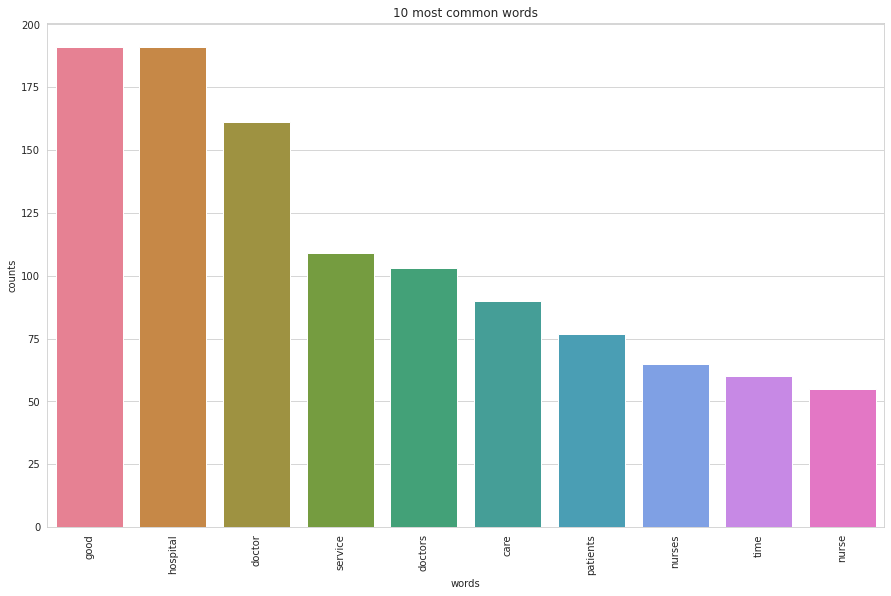

In [61]:
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

tokenized_sents_processed = pd.concat([rama_tokenized_sents_processed, phy2_tokenized_sents_processed], ignore_index=True) # Concat between Rama & Phyathai2

count_vectorizer = CountVectorizer(stop_words='english')                       # Initialise the count vectorizer with the English stop words
count_data = count_vectorizer.fit_transform(tokenized_sents_processed)         # Fit and transform the processed titles
plot_10_most_common_words(count_data, count_vectorizer)                        # Visualise the 10 most common words

In [62]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(tokenized_sents_processed)
print(X.shape)
print(vectorizer.get_feature_names())

(1141, 1708)
['aaa', 'abdomen', 'abdominal', 'ability', 'about', 'above', 'abscesses', 'abusive', 'abyss', 'access', 'accessible', 'accident', 'according', 'account', 'accuracy', 'acne', 'act', 'acted', 'acting', 'actually', 'add', 'adding', 'additional', 'address', 'aditheb', 'adjacent', 'administrator', 'admission', 'admit', 'admitted', 'advance', 'advanced', 'advice', 'advise', 'advised', 'advises', 'affordable', 'afraid', 'after', 'afternoon', 'again', 'against', 'aged', 'agi', 'ago', 'aided', 'air', 'alcoholics', 'all', 'allow', 'almost', 'alone', 'along', 'already', 'also', 'always', 'alzheimer', 'am', 'amazed', 'ambulance', 'amedotamgataer', 'amen', 'an', 'anc', 'and', 'angiography', 'ann', 'annual', 'another', 'answer', 'answers', 'antenatal', 'antibiotics', 'anxiety', 'any', 'anyone', 'anything', 'anyway', 'apparel', 'appendicitis', 'appication', 'applied', 'appointed', 'appointment', 'appreciate', 'approval', 'apr', 'april', 'architecture', 'are', 'areas', 'arma', 'arms', 'ar

In [63]:
pd.set_option('display.max_rows', None)

feature_names = vectorizer.get_feature_names()
dist = np.sum(X, axis=0)
df = pd.DataFrame(dist, columns=feature_names)
print(df.T)

                         0
aaa               0.556991
abdomen           0.217487
abdominal         1.511681
ability           1.328378
about             6.396349
above             0.352442
abscesses         0.454965
abusive           0.348293
abyss             0.294855
access            1.310922
accessible        0.230275
accident          1.560948
according         0.893202
account           0.402919
accuracy          1.169578
acne              0.217487
act               0.327065
acted             0.218722
acting            0.606492
actually          0.218722
add               0.919271
adding            0.217487
additional        0.522220
address           0.461195
aditheb           0.403206
adjacent          0.635204
administrator     0.729809
admission         0.321644
admit             1.006439
admitted          3.503213
advance           1.122628
advanced          0.592933
advice            8.882357
advise            0.753587
advised           2.758032
advises           0.547489
a

### 4) LDA vectorization

In [65]:
lda = LDA(n_components=10, n_jobs=-1)
lda.fit(count_data)

LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
pyLDAvis.display(LDAvis_prepared)

# Model

### Logistic Regression

In [71]:
import warnings
warnings.filterwarnings('ignore')

y = pd.concat([rama_data.scores, phy2_data.scores], ignore_index=True) # Concat between Rama & Phyathai2

grid = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg_cv = GridSearchCV(LogisticRegression(), grid, cv=10)
logreg_cv.fit(X, y)

print(logreg_cv.predict(X[:2, :]))
print(logreg_cv.predict_proba(X[:2, :]).shape)
print(logreg_cv.score(X, y))

[1 1]
(2, 2)
0.7563540753724802


### Decision tree classifier

In [69]:
params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)
grid_search_cv.fit(X, y)

print(grid_search_cv.predict(X[:2, :]))
print(grid_search_cv.predict_proba(X[:2, :]).shape)
print(grid_search_cv.score(X, y))

Fitting 3 folds for each of 294 candidates, totalling 882 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[1 1]
(2, 2)
0.7633654688869412


[Parallel(n_jobs=1)]: Done 882 out of 882 | elapsed:   46.1s finished


### Naive Bayes Classifier

In [76]:
grid = {}
gs = GridSearchCV(GaussianNB(), cv=StratifiedKFold(n_splits=10), param_grid=grid, return_train_score=True)
gs.fit(X.toarray(), y)

print(gs.predict(X.toarray()[:2, :]))
print(gs.predict_proba(X.toarray()[:2, :]).shape)
print(gs.score(X.toarray(), y))

[1 0]
(2, 2)
0.7931638913234005


# Visualization

### Some example of Parsing

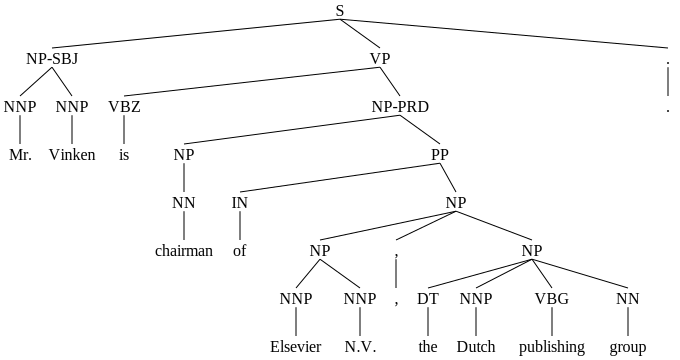

In [117]:
sentence = pd.concat([rama_data.sentences, phy2_data.sentences], ignore_index=True) # Concat between Rama & Phyathai2
tokens = [nltk.word_tokenize(i) for i in sentence]
tagged = [nltk.pos_tag(i) for i in tokens]
entities = [nltk.chunk.ne_chunk(i) for i in tagged]
t = treebank.parsed_sents('wsj_0001.mrg')[1]
svgling.draw_tree(t)

### Wordcloud

(-0.5, 399.5, 199.5, -0.5)

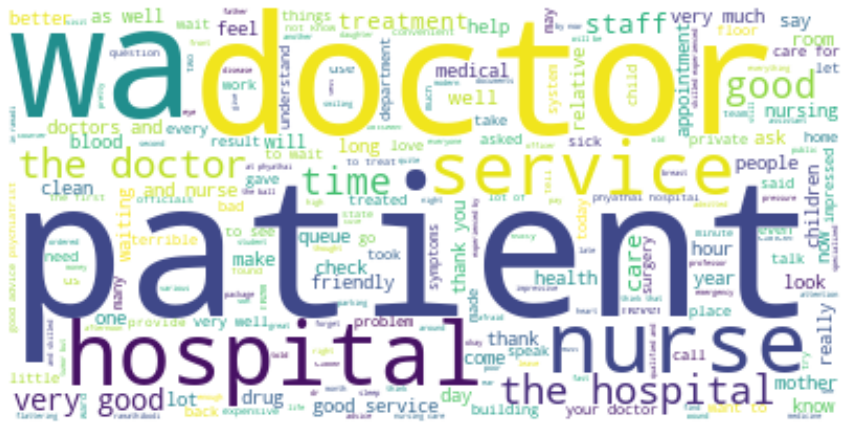

In [118]:
# Ramathibodi Hospital

long_string = ','.join(list(rama_tokenized_sents_processed.values))                                          # Join the different processed titles together
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')  # Create a WordCloud object
wordcloud.generate(long_string)                                                                              # Generate a word cloud
plt.figure(figsize=(15,10))                                                                                  # Visualize the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
#wordcloud.to_image()

(-0.5, 399.5, 199.5, -0.5)

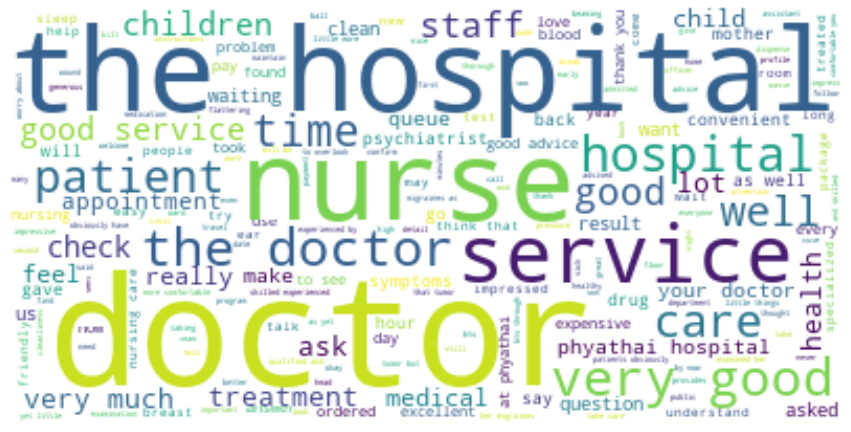

In [119]:
# Phyathai2 Hospital

long_string = ','.join(list(phy2_tokenized_sents_processed.values))                                               # Join the different processed titles together
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')  # Create a WordCloud object
wordcloud.generate(long_string)                                                                              # Generate a word cloud
plt.figure(figsize=(15,10))                                                                                  # Visualize the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
#wordcloud.to_image()